#### [RQ1] In what period of the year Taxis are used more? 

Create a plot that, for each month, shows the average number of trips recorded each day. Due to the differences among New York zones, we want to visualize the same information for each boroughs. Do you notice any difference among them? Provide comments and plausible explanations about what you observe (e.g.: what is the month with the highest daily average?).

In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

In [2]:
# importing data set, with only columns we need for current analysis
data = pd.read_csv('yellow_tripdata_2018-01.csv', usecols = ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'trip_distance', 'PULocationID', 'total_amount'])

In [3]:
data.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,PULocationID,total_amount
0,2018-01-01 00:21:05,2018-01-01 00:24:23,0.5,41,5.80
1,2018-01-01 00:44:55,2018-01-01 01:03:05,2.7,239,15.30
2,2018-01-01 00:08:26,2018-01-01 00:14:21,0.8,262,8.30
3,2018-01-01 00:20:22,2018-01-01 00:52:51,10.2,140,34.80
4,2018-01-01 00:09:18,2018-01-01 00:27:06,2.5,246,16.55


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8759874 entries, 0 to 8759873
Data columns (total 5 columns):
tpep_pickup_datetime     object
tpep_dropoff_datetime    object
trip_distance            float64
PULocationID             int64
total_amount             float64
dtypes: float64(2), int64(1), object(2)
memory usage: 334.2+ MB


In [5]:
# we decided to change the type of DataFrame columns to datetime,
# because we need the length of the trips for further DataFrame filtering
data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'])
data['tpep_dropoff_datetime'] = pd.to_datetime(data['tpep_dropoff_datetime'])

In [6]:
# we noticed that pickup dates also has some strange data,
# and as we are investigating only speciefic month,
# we decided to clean everything what happened on other time.
data['tpep_pickup_datetime'].describe()

count                 8759874
unique                2311493
top       2018-01-27 15:15:26
freq                       41
first     2001-01-05 11:45:23
last      2018-07-27 04:06:37
Name: tpep_pickup_datetime, dtype: object

In [7]:
# we need these columns for cleaning data by filtering
data['month'] = pd.DatetimeIndex(data['tpep_pickup_datetime']).month
data['year'] = pd.DatetimeIndex(data['tpep_pickup_datetime']).year
# filtering dataframe
data = data[(data['month'] == 1) & (data['year'] == 2018)]
# calculating the number of the days in current month
number_of_days = (calendar.monthrange(2018, 1))[1] 

In [8]:
lookup_data = pd.read_csv('taxi _zone_lookup.csv')

In [9]:
lookup_data.head()

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


In [10]:
# We merged on 'PULocationID' because we are going to investigate dataset watching to the area of departure
Data = pd.merge(data, lookup_data, left_on = data['PULocationID'], right_on = lookup_data['LocationID'])

In [11]:
Data.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,PULocationID,total_amount,month,year,LocationID,Borough,Zone,service_zone
0,2018-01-01 00:21:05,2018-01-01 00:24:23,0.50,41,5.80,1,2018,41,Manhattan,Central Harlem,Boro Zone
1,2018-01-01 00:49:32,2018-01-01 00:59:52,1.36,41,9.80,1,2018,41,Manhattan,Central Harlem,Boro Zone
2,2018-01-01 00:11:56,2018-01-01 00:14:35,0.30,41,5.30,1,2018,41,Manhattan,Central Harlem,Boro Zone
3,2018-01-01 00:58:32,2018-01-01 01:43:45,14.10,41,60.66,1,2018,41,Manhattan,Central Harlem,Boro Zone
4,2018-01-01 00:14:09,2018-01-01 00:44:06,8.77,41,36.36,1,2018,41,Manhattan,Central Harlem,Boro Zone


In [12]:
del data

In [13]:
del lookup_data

In [14]:
# deleting columns month and year as we dont need them anymore
Data = Data.drop(labels=['month','year'], axis=1)

Firstly we decided to clean our data from the fake trips.

In [15]:
# column 'trip_time_delta' is the representation of duration of a ride in minutes
# column 'taxi_speed' is the average speed of moving in miles per hour

trip_time_delta = Data['tpep_dropoff_datetime'] - Data['tpep_pickup_datetime']
trip_time_delta = trip_time_delta.dt.total_seconds().astype(int)
Data['trip_time_delta'] = trip_time_delta / 60
Data['taxi_speed'] = Data['trip_distance'] / (Data['trip_time_delta'] / 60)

We decided to cut off all the rides with driving speed less than 2,
as the average speed in the slowest part of NY is 5 miles/h (according to NY post from June 15, 2018).
We also left this 3 miles/h gap for traffic jams and accidents. 

By doing this we lost all the trips with trip_distance = 0,
but anyway we were not able to assess if these trips are fake or not.

We cut off all the rides with speed more than 65 miles/h as this is the highest allowed speed in NY area and it works only for speciefic 'fast' roads, so it's impossible to drive all the trip with average speed more than that.

We clean all the data with departure borough equals to 'Unknown', as we can not get any useful information from this data, when it comes to analyzing the number of trips recorded in each NY area.

In [16]:
Data = Data[(Data['taxi_speed'] >= 2) & (Data['trip_time_delta'] >= 1) & (Data['taxi_speed'] < 65) & (Data['Borough'] != 'Unknown')]

In [17]:
 # avg_number_of_rides is a list which stores data about the average number of trips for each month
avg_number_of_rides = [(Data['Borough'].value_counts())//number_of_days]

In [18]:
avg_number_of_rides[0].index

Index(['Manhattan', 'Queens', 'Brooklyn', 'Bronx', 'Staten Island', 'EWR'], dtype='object')

In [19]:
avg_number_of_rides[0].values

array([254378,  16408,   3141,    207,      2,      1], dtype=int64)

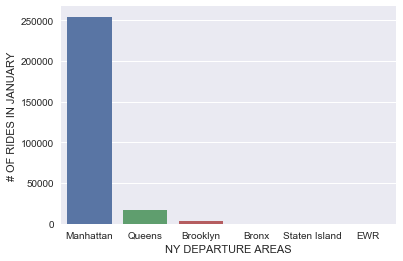

In [20]:
sns.set(style="darkgrid")
ax = sns.barplot(avg_number_of_rides[0].index, avg_number_of_rides[0].values)
ax.set(xlabel='NY DEPARTURE AREAS', ylabel='# OF RIDES IN JANUARY')
plt.show()

In [21]:
del Data

Furter we do all the same operations with data sets for all other months, using for loop.
Appending list avg_number_of_rides on each iteraion of the loop.
At the end we have list avg_number_of_rides which stores all required data about average number of trips for each NY area for each month.

In [22]:
for M in range(2,7):
    data = pd.read_csv('yellow_tripdata_2018-0' + str(M) + '.csv', usecols = ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'trip_distance', 'PULocationID', 'total_amount'])
    data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'])
    data['tpep_dropoff_datetime'] = pd.to_datetime(data['tpep_dropoff_datetime'])
    data['month'] = pd.DatetimeIndex(data['tpep_pickup_datetime']).month
    data['year'] = pd.DatetimeIndex(data['tpep_pickup_datetime']).year
    data = data[(data['month'] == M) & (data['year'] == 2018)]
    number_of_days = (calendar.monthrange(2018, M))[1] 
    lookup_data = pd.read_csv('taxi _zone_lookup.csv')
    Data = pd.merge(data, lookup_data, left_on = data['PULocationID'], right_on = lookup_data['LocationID'])
    del data
    del lookup_data
    Data = Data.drop(labels=['month','year'], axis=1)
    trip_time_delta = Data['tpep_dropoff_datetime'] - Data['tpep_pickup_datetime']
    trip_time_delta = trip_time_delta.dt.total_seconds().astype(int)
    Data['trip_time_delta'] = trip_time_delta / 60
    Data['taxi_speed'] = Data['trip_distance'] / (Data['trip_time_delta'] / 60)
    Data = Data[(Data['taxi_speed'] >= 2) & (Data['trip_time_delta'] >= 1) & (Data['taxi_speed'] < 65) & (Data['Borough'] != 'Unknown')]
    avg_number_of_rides.append((Data['Borough'].value_counts())//number_of_days)
    del Data

In [23]:
# rides is a dataframe made from elements of the list avg_number_of_rides, which are Series
# we are also renaming columns of rides and transposing it for better looking
rides = pd.concat([avg_number_of_rides[0], avg_number_of_rides[1], avg_number_of_rides[2], avg_number_of_rides[3], avg_number_of_rides[4], avg_number_of_rides[5]], axis=1)
rides.columns = ['01', '02', '03', '04', '05', '06']
rides = rides.transpose()

In [24]:
rides

,Manhattan,Queens,Brooklyn,Bronx,Staten Island,EWR
01,254378,16408,3141,207,2,1
02,274698,16695,3299,204,2,1
03,273356,17548,3856,302,2,1
04,278044,19200,3861,320,2,1
05,266384,19021,3853,322,2,2
06,259572,18403,3986,312,3,1


##### Plots for each month, shows the average number of trips recorded each day:

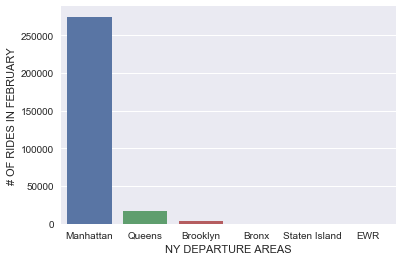

In [28]:
# FEBRUARY
ax = sns.barplot(avg_number_of_rides[1].index, avg_number_of_rides[1].values)
ax.set(xlabel='NY DEPARTURE AREAS', ylabel='# OF RIDES IN FEBRUARY')
plt.show()

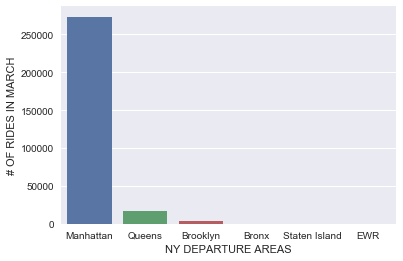

In [29]:
# MARCH
ax = sns.barplot(avg_number_of_rides[2].index, avg_number_of_rides[2].values)
ax.set(xlabel='NY DEPARTURE AREAS', ylabel='# OF RIDES IN MARCH')
plt.show()

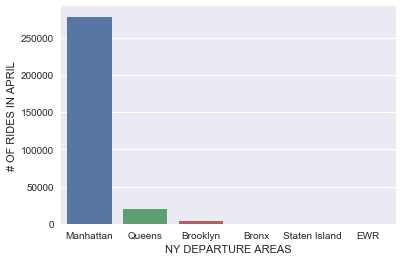

In [30]:
# APRIL
ax = sns.barplot(avg_number_of_rides[3].index, avg_number_of_rides[3].values)
ax.set(xlabel='NY DEPARTURE AREAS', ylabel='# OF RIDES IN APRIL')
plt.show()

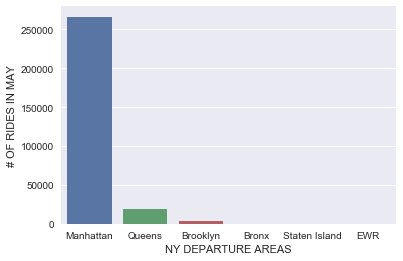

In [31]:
# MAY
ax = sns.barplot(avg_number_of_rides[4].index, avg_number_of_rides[4].values)
ax.set(xlabel='NY DEPARTURE AREAS', ylabel='# OF RIDES IN MAY')
plt.show()

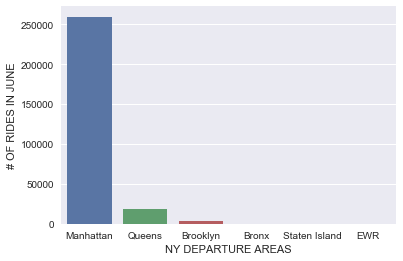

In [32]:
# JUNE
ax = sns.barplot(avg_number_of_rides[5].index, avg_number_of_rides[5].values)
ax.set(xlabel='NY DEPARTURE AREAS', ylabel='# OF RIDES IN JUNE')
plt.show()

#### Plots for the average number of trips recorded each day for each borough:

In [33]:
rides

,Manhattan,Queens,Brooklyn,Bronx,Staten Island,EWR
01,254378,16408,3141,207,2,1
02,274698,16695,3299,204,2,1
03,273356,17548,3856,302,2,1
04,278044,19200,3861,320,2,1
05,266384,19021,3853,322,2,2
06,259572,18403,3986,312,3,1


From the table above it is easily seen that the main number of rides go to Manhattan borough. The figures for this area vary from 254 to 278 thousands, depending on the month.

Second top is Queens with 16-19 thousands, right after it goes Brooklyn with 3 thousands and Bronx with 200-300 rides per day.

Staten Island and EWR boroughs show insignificant usage of taxi.

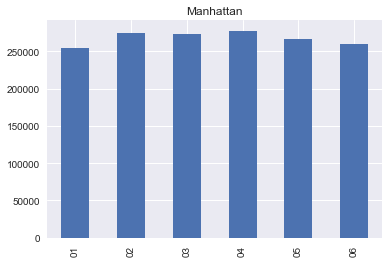

In [37]:
rides['Manhattan'].plot(kind='bar', title='Manhattan')
plt.show()

Manhattan shows the biggest demand of taxis. Each day taxi drivers make 254-278 thousands of rides, however this 8% flactuation looks insignificant, so we can say that the average number of rides barely varies during represented months.
However, the highest pick was gained in April with 278044 rides per day. From February to April it was higher than 278 thousand, and the the lowest month was January with 254378 rides/day.

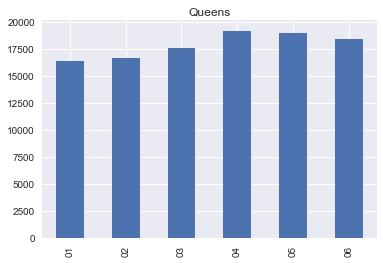

In [38]:
rides['Queens'].plot(kind='bar', title='Queens')
plt.show()

Queens' taxi drivers serve about 16-19 thousands rides each day. From the begining of the year the number goes up from 16408 and picks in April with 19200, then slightly decreases, reaching 18403 by June.

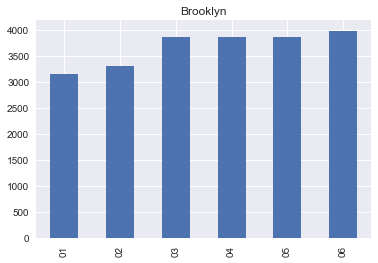

In [39]:
rides['Brooklyn'].plot(kind='bar', title='Brooklyn')
plt.show()

Brooklyn is the third  popular taxi departure zone. Here figures for the daily average number flactuate from 3141 to 3986, reaching the peak in June. Even though this growth does not look significant, however the difference between January and June is 21%.

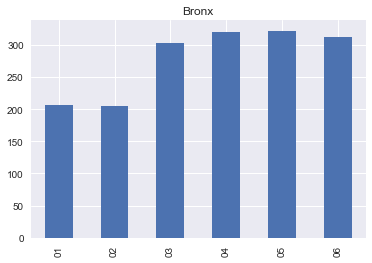

In [43]:
rides['Bronx'].plot(kind='bar', title='Bronx')
plt.show()

Bronx is on the fourth place with number of rides from 204 to 322. Winter months such as January and Februare are the less popular among passengers (the same tendency is shown in Brooklyn). The top month for Bronx is May with 322 daily rides.

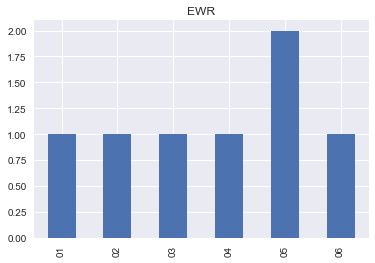

In [42]:
rides['EWR'].plot(kind='bar', title='EWR')
plt.show()

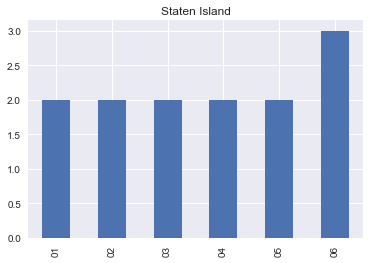

In [41]:
rides['Staten Island'].plot(kind='bar', title='Staten Island')
plt.show()

When it comes to EWR and Staten Island these two areas are the least popular for taking a taxi, according to our data. As the daily average number of taxi rides varies in a range from 1 to 3 rides per day. So we can say that this districs almost do not use taxi, or what is more possible, the taxi cars store data about these rides in a wrong way, for example they do not save 'PULocationID'.

When we are talking about the whole NY area:

In [77]:
NY = pd.DataFrame({'avg per month': [rides.loc['01'].sum(),rides.loc['02'].sum(),rides.loc['03'].sum(),rides.loc['04'].sum(),rides.loc['05'].sum(),rides.loc['06'].sum()]}, index = ['01', '02', '03', '04', '05', '06'])

In [78]:
NY

,avg per month
01,274137
02,294899
03,295065
04,301428
05,289584
06,282277


In [83]:
# the most active month across the whole NY was April with the next daily average number of rides per day:
NY['avg per month'].max()

301428

In [84]:
# the least active was January:
NY['avg per month'].min()

274137

In [86]:
# the average for these 6 months is:
NY['avg per month'].mean()

289565.0

#### [RQ2] What are the time slots with more passengers?

Set your own time slots and discover which are those when Taxis drive the highest number of passengers overall New York and repeat the analysis for each borough. Provide the results through a visualization and comment them.

In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import numpy as np

In [2]:
# importing data set, with only columns we need for current analysis
data = pd.read_csv('yellow_tripdata_2018-01.csv', usecols = ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count','trip_distance', 'PULocationID'])

In [3]:
data.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID
0,2018-01-01 00:21:05,2018-01-01 00:24:23,1,0.5,41
1,2018-01-01 00:44:55,2018-01-01 01:03:05,1,2.7,239
2,2018-01-01 00:08:26,2018-01-01 00:14:21,2,0.8,262
3,2018-01-01 00:20:22,2018-01-01 00:52:51,1,10.2,140
4,2018-01-01 00:09:18,2018-01-01 00:27:06,2,2.5,246


In [4]:
# we decided to change the type of DataFrame columns to datetime,
# because we need the length of the trips for further DataFrame filtering
data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'])
data['tpep_dropoff_datetime'] = pd.to_datetime(data['tpep_dropoff_datetime'])

In [5]:
# we need these columns for cleaning data by filtering
data['month'] = pd.DatetimeIndex(data['tpep_pickup_datetime']).month
data['year'] = pd.DatetimeIndex(data['tpep_pickup_datetime']).year
# filtering dataframe
data = data[(data['month'] == 1) & (data['year'] == 2018)]

In [6]:
lookup_data = pd.read_csv('taxi _zone_lookup.csv')

In [7]:
# We merged on 'PULocationID' because we are going to investigate dataset watching to the area of departure
Data = pd.merge(data, lookup_data, left_on = data['PULocationID'], right_on = lookup_data['LocationID'])

In [8]:
del data

In [9]:
del lookup_data

In [10]:
# deleting columns month and year as we dont need them anymore
Data = Data.drop(labels=['month','year'], axis=1)

Firstly we decided to clean our data from the fake trips.

In [11]:
# column 'trip_time_delta' is the representation of duration of a ride in minutes
# column 'taxi_speed' is the average speed of moving in miles per hour

trip_time_delta = Data['tpep_dropoff_datetime'] - Data['tpep_pickup_datetime']
trip_time_delta = trip_time_delta.dt.total_seconds().astype(int)
Data['trip_time_delta'] = trip_time_delta / 60
Data['taxi_speed'] = Data['trip_distance'] / (Data['trip_time_delta'] / 60)

We decided to cut off all the rides with driving speed less than 2,
as the average speed in the slowest part of NY is 5 miles/h (according to NY post from June 15, 2018).
We also left this 3 miles/h gap for traffic jams and accidents. 

By doing this we lost all the trips with trip_distance = 0,
but anyway we were not able to assess if these trips are fake or not.

We cut off all the rides with speed more than 65 miles/h as this is the highest allowed speed in NY area and it works only for speciefic 'fast' roads, so it's impossible to drive all the trip with average speed more than that.

We clean all the data with departure borough equals to 'Unknown', as we can not get any useful information from this data, when it comes to analyzing the number of trips recorded in each NY area.

In [12]:
Data = Data[(Data['taxi_speed'] >= 2) & (Data['trip_time_delta'] >= 1) & (Data['taxi_speed'] < 65) & (Data['Borough'] != 'Unknown')]

In [13]:
Data.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,LocationID,Borough,Zone,service_zone,trip_time_delta,taxi_speed
0,2018-01-01 00:21:05,2018-01-01 00:24:23,1,0.50,41,41,Manhattan,Central Harlem,Boro Zone,3.300000,9.090909
1,2018-01-01 00:49:32,2018-01-01 00:59:52,1,1.36,41,41,Manhattan,Central Harlem,Boro Zone,10.333333,7.896774
2,2018-01-01 00:11:56,2018-01-01 00:14:35,2,0.30,41,41,Manhattan,Central Harlem,Boro Zone,2.650000,6.792453
3,2018-01-01 00:58:32,2018-01-01 01:43:45,1,14.10,41,41,Manhattan,Central Harlem,Boro Zone,45.216667,18.709915
4,2018-01-01 00:14:09,2018-01-01 00:44:06,1,8.77,41,41,Manhattan,Central Harlem,Boro Zone,29.950000,17.569282


In [14]:
# we replace the number of passengers to 1 in case it was not inserted by driver
Data['passenger_count'] = np.where(Data['passenger_count'] < 1, 1, Data['passenger_count'])

In [15]:
# we replace the number of passengers to 4 in case it is higher than 4, for example 9, as according to taxi rools
# it is not possible to fit more than 4 passengers in one car. So we decided to leave these rides with suspicious
# number of passangers, but decreise the number of people to maximum tixi capacity.
Data['passenger_count'] = np.where(Data['passenger_count'] > 4, 4, Data['passenger_count'])

In [16]:
# we are creating a new column to divide our data set into time slots
Data['hour'] = pd.DatetimeIndex(Data['tpep_pickup_datetime']).hour

In [17]:
Data['time_slot'] = Data['hour']

Our time slots are: night [23.00, 04.00], morning [5.00, 10.00], day [11.00, 16.00], evening [17.00, 22.00].

In [18]:
Data['time_slot']= Data['time_slot'].replace([23,0,1,2,3,4],'night')
Data['time_slot']= Data['time_slot'].replace([5,6,7,8,9,10],'morning')
Data['time_slot']= Data['time_slot'].replace([11,12, 13,14,15,16],'day')
Data['time_slot']= Data['time_slot'].replace([17,18,19,20,21,22],'evening')

In [19]:
# we are dropping columns, which we do not need anymore to operate with smaller data set
Data = Data.drop(labels=['tpep_pickup_datetime','tpep_dropoff_datetime', 'trip_distance', 'Zone', 'service_zone', 'trip_time_delta', 'taxi_speed', 'hour'], axis=1)

In [20]:
Data.head()

,passenger_count,PULocationID,LocationID,Borough,time_slot
0,1,41,41,Manhattan,night
1,1,41,41,Manhattan,night
2,2,41,41,Manhattan,night
3,1,41,41,Manhattan,night
4,1,41,41,Manhattan,night


In [21]:
# here we creating a list which stores series with the number of passengers for each time slot and for each NY zone
pass_for_each_zone = [Data.groupby(['Borough','time_slot'])['passenger_count'].sum()]

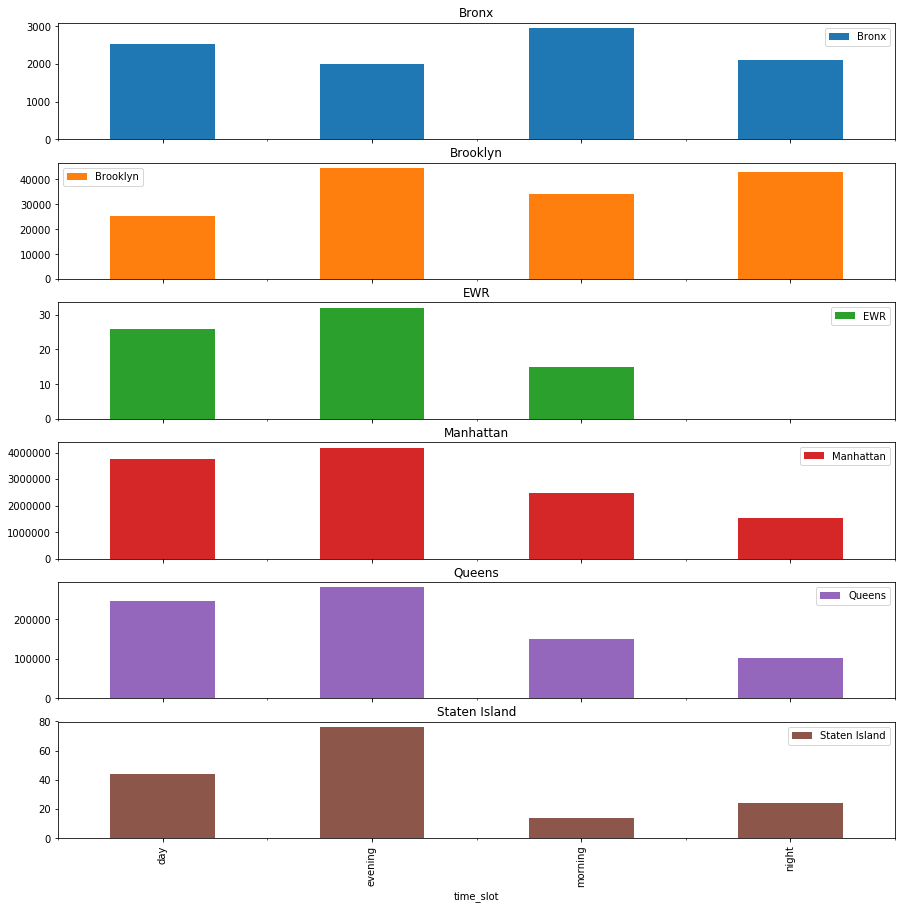

In [22]:
# here it's representation for January 
pass_for_each_zone[0].unstack(level=0).plot(kind='bar', figsize = (15,15), subplots=True)
plt.show()

In [23]:
# list which stores the number of passengers for each month for the whole NY
time_slots_lst = [Data.groupby('time_slot')['passenger_count'].sum()]

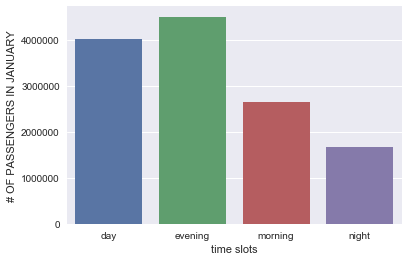

In [24]:
# it's representation for January
sns.set(style="darkgrid")
ax = sns.barplot(time_slots_lst[0].index, time_slots_lst[0].values)
ax.set(xlabel='time slots', ylabel='# OF PASSENGERS IN JANUARY')
plt.show()

In [25]:
del Data

Furter we do all the same operations with data sets for all other months, using for loop.
Appending lists pass_for_each_zone and time_slots_lst on each iteraion of the loop.
At the end we have list pass_for_each_zone which stores all required data about the number of passengers for each NY area for each month and list time_slots_lst which stores the number of passengers for the whole NY.

In [26]:
for M in range(2,7):
    data = pd.read_csv('yellow_tripdata_2018-0' + str(M) + '.csv', usecols = ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count','trip_distance', 'PULocationID'])
    data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'])
    data['tpep_dropoff_datetime'] = pd.to_datetime(data['tpep_dropoff_datetime'])
    data['month'] = pd.DatetimeIndex(data['tpep_pickup_datetime']).month
    data['year'] = pd.DatetimeIndex(data['tpep_pickup_datetime']).year
    data = data[(data['month'] == M) & (data['year'] == 2018)]
    lookup_data = pd.read_csv('taxi _zone_lookup.csv')
    Data = pd.merge(data, lookup_data, left_on = data['PULocationID'], right_on = lookup_data['LocationID'])
    del data
    del lookup_data
    Data = Data.drop(labels=['month','year'], axis=1)
    trip_time_delta = Data['tpep_dropoff_datetime'] - Data['tpep_pickup_datetime']
    trip_time_delta = trip_time_delta.dt.total_seconds().astype(int)
    Data['trip_time_delta'] = trip_time_delta / 60
    Data['taxi_speed'] = Data['trip_distance'] / (Data['trip_time_delta'] / 60)
    Data = Data[(Data['taxi_speed'] >= 2) & (Data['trip_time_delta'] >= 1) & (Data['taxi_speed'] < 65) & (Data['Borough'] != 'Unknown')]
    Data['passenger_count'] = np.where(Data['passenger_count'] < 1, 1, Data['passenger_count'])
    Data['passenger_count'] = np.where(Data['passenger_count'] > 4, 4, Data['passenger_count'])
    Data['hour'] = pd.DatetimeIndex(Data['tpep_pickup_datetime']).hour
    Data['time_slot'] = Data['hour']
    Data['time_slot']= Data['time_slot'].replace([23,0,1,2,3,4],'night')
    Data['time_slot']= Data['time_slot'].replace([5,6,7,8,9,10],'morning')
    Data['time_slot']= Data['time_slot'].replace([11,12, 13,14,15,16],'day')
    Data['time_slot']= Data['time_slot'].replace([17,18,19,20,21,22],'evening')
    Data = Data.drop(labels=['tpep_pickup_datetime','tpep_dropoff_datetime', 'trip_distance', 'Zone', 'service_zone', 'trip_time_delta', 'taxi_speed', 'hour'], axis=1)
    time_slots_lst.append(Data.groupby('time_slot')['passenger_count'].sum())
    pass_for_each_zone.append(Data.groupby(['Borough','time_slot'])['passenger_count'].sum())
    del Data

In [27]:
# passenger_num is a dataframe with the number of passengers for the whole NY for each month for each time slot
passenger_num = pd.concat([time_slots_lst[0], time_slots_lst[1], time_slots_lst[2], time_slots_lst[3], time_slots_lst[4], time_slots_lst[5]], axis=1)
passenger_num.columns = ['01', '02', '03', '04', '05', '06']
passenger_num = passenger_num.transpose()

In [28]:
passenger_num

time_slot,day,evening,morning,night
01,4021755,4510291,2642312,1677681
02,3887164,4404439,2524483,1603580
03,4216601,4904417,2825750,1871301
04,4197611,4892002,2774992,1797272
05,4179255,4773069,2806406,1762902
06,3895442,4474404,2587435,1818105


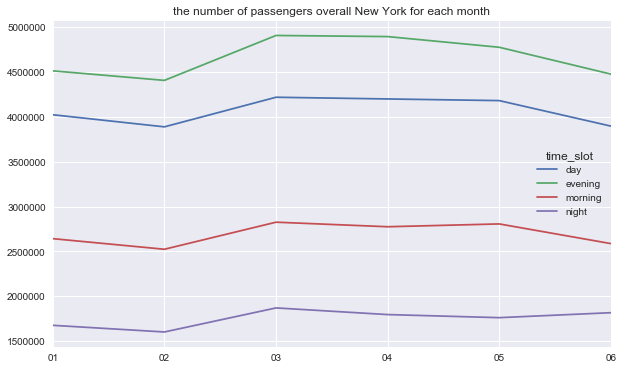

In [29]:
passenger_num.plot(figsize = (10,6), title = 'the number of passengers overall New York for each month')
plt.show()

We have next timeslots: night [23.00, 04.00], morning [5.00, 10.00], day [11.00, 16.00], evening [17.00, 22.00].
It is easily seen that in the evening the greatest number of people use taxi, while the number of people who use it at night is a bit more then one third of it. Second top time zone is day, and the third is morning, however in the morning significantly less people use taxi than in the evening. 
When it comes to months, in March taxis had the biggest number of passengers in all time slots. At the same time spring from March to May was a heavy time, while after it we can see decline. The only rise in all four graphics can be seen in the period from February to March. Another inetersing feature is that the only graph which went up after May is a 'night' one. So more people used taxi at night in June then during Spring months.

In [30]:
# passenger_num_zone is a dataframe with the number of passengers for each NY area for each month for each time slot
passenger_num_zone = pd.concat([pass_for_each_zone[0], pass_for_each_zone[1], pass_for_each_zone[2], pass_for_each_zone[3], pass_for_each_zone[4], pass_for_each_zone[5]], axis=1)
passenger_num_zone.columns = ['01', '02', '03', '04', '05', '06']
passenger_num_zone = passenger_num_zone.transpose()

In [31]:
passenger_num_zone

Borough     Bronx                         Brooklyn                             \
time_slot     day evening morning   night      day  evening  morning    night   
01         2524.0  2003.0  2947.0  2105.0  25205.0  44457.0  34033.0  42796.0   
02         2178.0  2154.0  2401.0  1683.0  24716.0  44450.0  29523.0  39516.0   
03         3612.0  3251.0  5280.0  2319.0  33129.0  57580.0  38063.0  52204.0   
04         4119.0  3384.0  5059.0  2272.0  33980.0  54145.0  37743.0  49239.0   
05         4169.0  3982.0  4953.0  2342.0  35019.0  59025.0  38752.0  47414.0   
06         4017.0  3631.0  4682.0  2330.0  33619.0  57496.0  36120.0  53126.0   

Borough     EWR          ...   Manhattan               Queens            \
time_slot   day evening  ...     morning      night       day   evening   
01         26.0    32.0  ...   2455618.0  1531478.0  244931.0  280194.0   
02         19.0    22.0  ...   2351569.0  1478582.0  226077.0  258762.0   
03         20.0    31.0  ...   2616467.0  1713595.0  260336.0  303380.0   
04         34.0    28.0  ...   2568225.0  1637231.0  286774.0  324660.0   
05         47.0    29.0  ...   2584141.0  1599198.0  293488.0  315222.0   
06         28.0    24.0  ...   2380541.0  1650187.0  271234.0  296861.0   

Borough                       Staten Island                        
time_slot   morning     night           day evening morning night  
01         149685.0  101278.0          44.0    76.0    14.0  24.0  
02         140967.0   83779.0          42.0    34.0     9.0  17.0  
03         165911.0  103153.0          48.0    23.0    11.0  30.0  
04         163917.0  108507.0          31.0    34.0    28.0  20.0  
05         178515.0  113909.0          40.0    44.0    24.0  36.0  
06         166025.0  112431.0          40.0    38.0    39.0  30.0  

[6 rows x 24 columns]

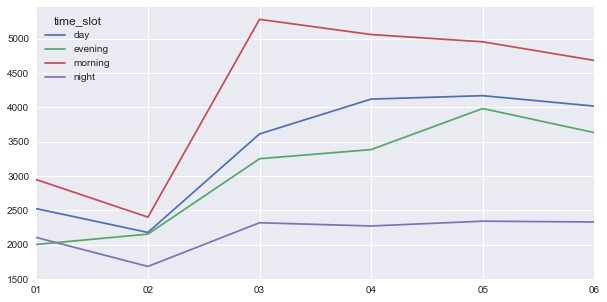

In [32]:
passenger_num_zone['Bronx'].plot(figsize = (10,5))
plt.show()

Here we can see that significantly more people took taxi from Bronx in morning time, after that goes day time and pretty close to it is evening graph. The night numder of passengers stays the smallest. 

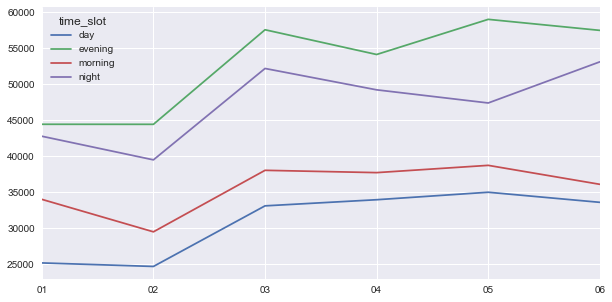

In [33]:
passenger_num_zone['Brooklyn'].plot(figsize = (10,5))
plt.show()

For Brooklyn we see that top number of passengers use taxi in the evening and a bit less during the night. Morning is the third popular time, while day number is roughly a half from evening figure.

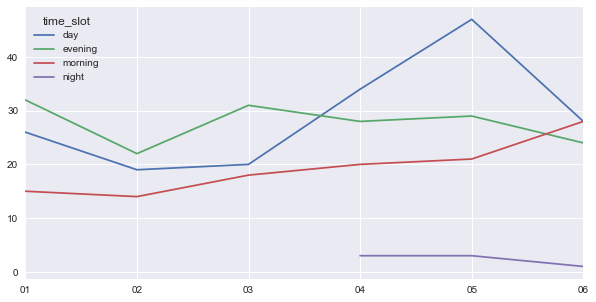

In [34]:
passenger_num_zone['EWR'].plot(figsize = (10,5))
plt.show()

For EWR zone we have relatuvely no data, but still while for three the time slots the number of passengers varies in between  15 to 35 passengers, for the night time there are only maximum 5 people per month or no at all.

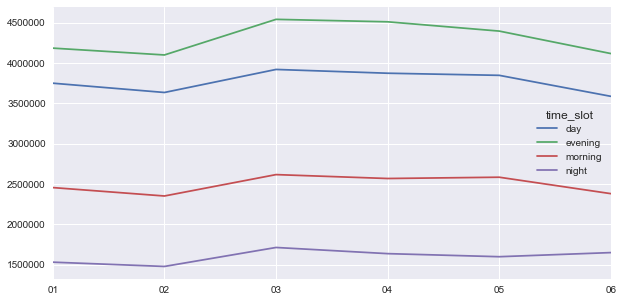

In [35]:
passenger_num_zone['Manhattan'].plot(figsize = (10,5))
plt.show()

The graph for Manhattan is absolutely the same as the graph for the whole NY, as the number of passengers who took taxi from it immensely outnumbers the number of passengers in all other areas. 

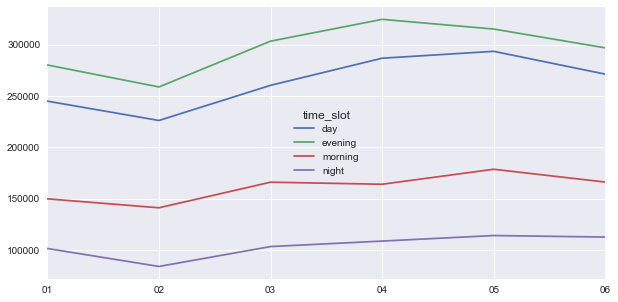

In [36]:
passenger_num_zone['Queens'].plot(figsize = (10,5))
plt.show()

The graph for Queens also reminds us the graph for Manhattan, but with a it smaller difference between evening and day.

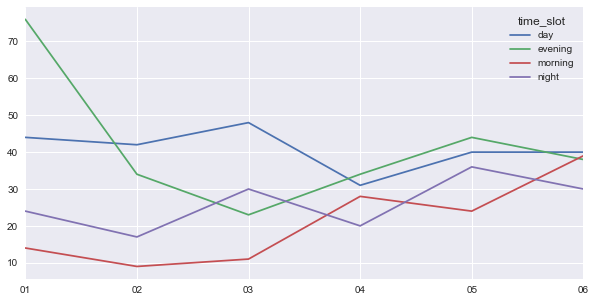

In [37]:
passenger_num_zone['Staten Island'].plot(figsize = (10,5))
plt.show()

The number of passengers departed from Staten Island varied strongly from 75 to 15  depending on the time slot till April, but then all the numbers stays almost in the same range. however, on average day and evening look as the most popular time for passengers.

## RQ3. Do the all trips last the same? 

Let's put our attention on the distribution of trip's duration. Provide a plot for it and comment what you see. Run this analysis for NYC and for each borough (and obviously comment the results!).

In [1]:
import pandas as pd
import datetime
from collections import defaultdict

In [2]:
# importing taxi zone datas
TZdf = pd.read_csv('taxi _zone_lookup.csv', encoding = 'ISO-8859-1')

In [3]:
# initializing a dictionary in which we will save every possible trip duration we will calculate, and how many times it appears 
a = defaultdict(int)
boroughs = ['Manhattan', 'Bronx', 'Queens', 'Staten Island', 'Brooklyn', 'EWR']
# initializing a dictionary divided by boroughs, in which we will save every possible trip duration we will calculate,
# and how many times it appears
dicts = {borough:defaultdict(int) for borough in boroughs}
for M in range(1,2):
    # importing data
    YCdf = pd.read_csv('yellow_tripdata_2018-0' + str(M) + '.csv', usecols = ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'trip_distance', 'PULocationID'])
    # merging data to see at which borough corresponds the location ID, and so we will be able to group by boroughs our data
    df = pd.merge(YCdf, TZdf, left_on = YCdf['PULocationID'], right_on = TZdf['LocationID'])
    del YCdf
    # calculating the trip duration in seconds
    df['tr_time'] = pd.to_datetime(df['tpep_dropoff_datetime'], format='%Y-%m-%d %H:%M:%S') - pd.to_datetime(df['tpep_pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
    l = sorted(list(map(lambda x : x.total_seconds(),df['tr_time'])))
    # saving in the dictionary how many times a trip duration appears, for the whole dataframe
    for s in l:
        a[s]+=1
    # creating a dataframe with just the columns we nneed to plot
    df2 = pd.DataFrame(df, columns=['Borough', 'tr_time'])
    del df
    # saving in the dictionary how many times a trip duration appears, divided for each borough 
    for borough in boroughs:
        dfM = pd.DataFrame(df2[df2['Borough'] == borough])
        L = sorted(list(map(lambda x : x.total_seconds(),dfM['tr_time'])))
        for S in L:
            dicts[borough][S]+=1
    del df2


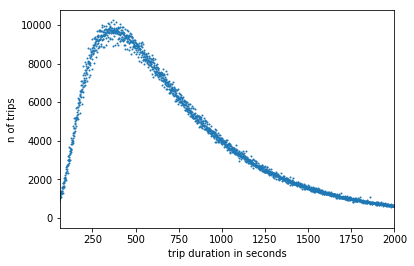

In [6]:
# we show a plot in which we have all the possible duration of the trips in seconds (x axis), 
# and how any times each appear on the dataframe (y axis)
df1 = pd.DataFrame(list(a.items()), columns = ['trip duration in seconds', 'n of trips'])
df1.plot(x = 'trip duration in seconds', y = 'n of trips', kind = 'scatter', xlim = [60, 2000], s = 1)

Looking at this plot we can say that mostly the duration of a trip is between 250 and 750 seconds, it means between about 5 and 15 minutes. We bounded the duration between 60 and 2000 seconds, or 1 and 30 minutes, because it seemed to have too few repetitions for longer trips.

Now we are going to study the distribution for each borough.

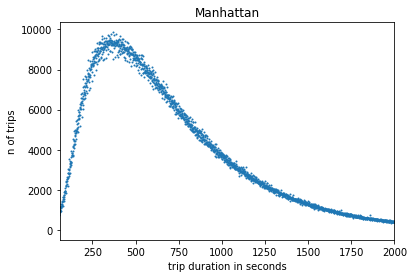

In [7]:
dfMan = pd.DataFrame(list(dicts['Manhattan'].items()), columns = ['trip duration in seconds', 'n of trips'])
dfMan.plot(x = 'trip duration in seconds', y = 'n of trips', xlim = [60, 2000], kind = 'scatter', s = 1, title = 'Manhattan')

For the trips in Manhattan we can see that are very similar to the general one, because we have many datas of Manhattan. So again we bound the duration between 1 and 30 minutes, and we can say that the majority of the trips last between 5 and 15 minutes.

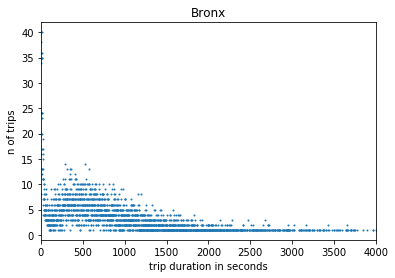

In [8]:
dfBrx = pd.DataFrame(list(dicts['Bronx'].items()), columns = ['trip duration in seconds', 'n of trips'])
dfBrx.plot(x = 'trip duration in seconds', y = 'n of trips', xlim = [0,4000], kind = 'scatter', s = 1, title = 'Bronx')

In Bronx we have more and less the same ranges, but much fewer repetitions, depending on the fewer data we have of the borough. So the duration range is between 2 and 40 minutes, a bit more than the one of Manhattan.

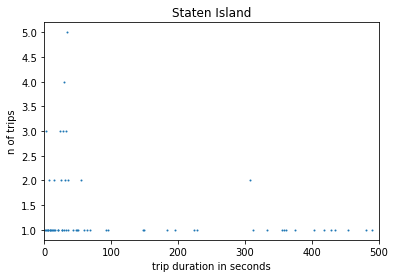

In [9]:
dfStIs = pd.DataFrame(list(dicts['Staten Island'].items()), columns = ['trip duration in seconds', 'n of trips'])
dfStIs.plot(x = 'trip duration in seconds', y = 'n of trips', xlim = [0 , 500], kind = 'scatter', s = 1, title = 'Staten Island')

For Staten Island we have even less datas, and we can see that the duration is very low. In fact we have more repetitions between 0 and 100 seconds, and it means that the maximum of a trip is 2 minutes. we can assume that there are too few datas to do a real comment, and that maybe the real trip are not the ones that last less than 2 minutes.

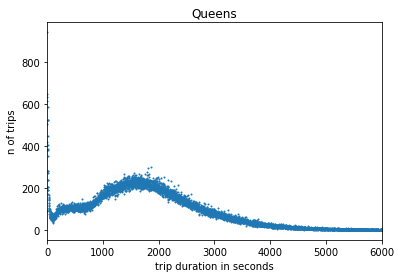

In [10]:
dfQue = pd.DataFrame(list(dicts['Queens'].items()), columns = ['trip duration in seconds', 'n of trips'])
dfQue.plot(x = 'trip duration in seconds', y = 'n of trips', xlim = [0, 6000], kind = 'scatter', s = 1, title = 'Queens')

In Queens we finally have enough datas, and we can observe that the range in which there are more repetitions is a bit larger than the others. We can say that it is between 100 and 3000 seconds, so 2 and 50 minutes.

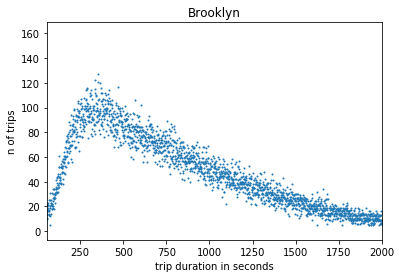

In [11]:
dfBrok = pd.DataFrame(list(dicts['Brooklyn'].items()), columns = ['trip duration in seconds', 'n of trips'])
dfBrok.plot(x = 'trip duration in seconds', y = 'n of trips',xlim = [60,2000], kind = 'scatter', s = 1, title = 'Brooklyn')

Even for Brooklyn we do not have many datas, but we can consider the range between 250 and 750 seconds, 5 and 15 minutes, the same as Manhattan.

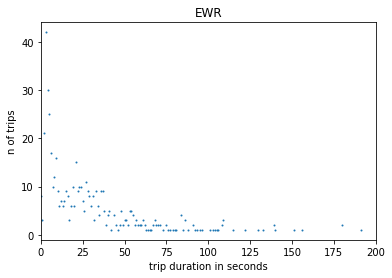

In [12]:
dfEWR = pd.DataFrame(list(dicts['EWR'].items()), columns = ['trip duration in seconds', 'n of trips'])
dfEWR.plot(x = 'trip duration in seconds', y = 'n of trips', xlim = [0, 200],kind = 'scatter', s = 1, title = 'EWR')

For EWR we have very few data, and we can do the same comment as the one of Staten Island. In fact the most of the trip, according to the plot, should last not more than 100 seconds, so 2 minutes. It is quite irrational, so we can say that they are not the real ones, but maybe we have just few trips, and the real ones are not equals from each others, so that are scattered in the x axis, with few repetitions.

## [RQ4] What is the most common way of payments?

Discover the way payments are executed in each borough and visualize the number of payments for any possible means. Then run the Chi-squared test to see whether the method of payment is correlated to the borough. Then, comment the results.

In [2]:
import pandas as pd
from collections import defaultdict
from scipy import stats

In [3]:
TZdf = pd.read_csv('taxi _zone_lookup.csv', encoding = 'ISO-8859-1')

In [4]:
YC = ['yellow_tripdata_2018-01.csv','yellow_tripdata_2018-02.csv','yellow_tripdata_2018-03.csv', 'yellow_tripdata_2018-04.csv', 'yellow_tripdata_2018-05.csv', 'yellow_tripdata_2018-06.csv']
boroughs = ['Manhattan', 'Bronx', 'Queens', 'Staten Island', 'Brooklyn', 'EWR']
# initializing a dictionary divided for NY boroughs
dicts = {borough:defaultdict(int) for borough in boroughs}
for i in YC:
    #importing datas
    YCdf = pd.read_csv(i, encoding = 'ISO-8859-1')
    # merging data to see at which borough corresponds the location ID, and so we will be able to group by boroughs our data    
    dfpay = pd.merge(YCdf, TZdf, left_on = YCdf['PULocationID'], right_on = TZdf['LocationID'])
    del YCdf
    # we take in account just the two columns we need
    dfpay = dfpay.loc[:,['payment_type','Borough']]
    for borough in boroughs:
        # we store how many times a payment method is used for each borough in our dictionary
        dfbor = dfpay[dfpay['Borough'] == borough]
        for pt in dfbor['payment_type']:
            dicts[borough][pt]+=1


Stored our datas, we are going to visualize and comment them.

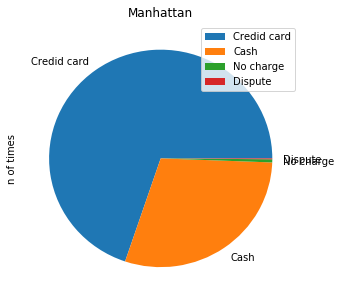

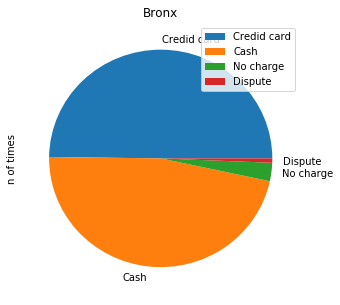

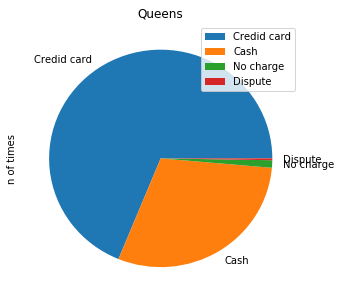

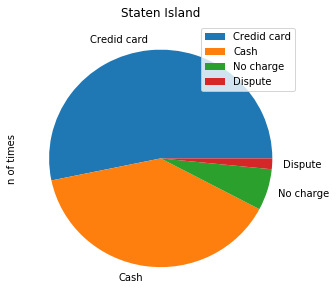

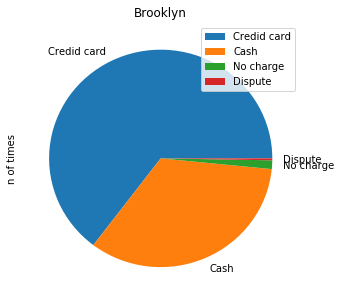

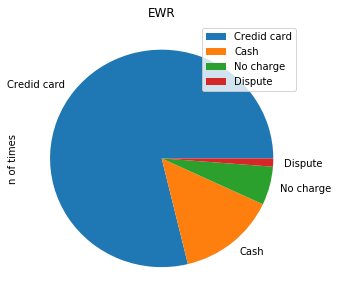

In [6]:
plots = []
for borough in boroughs:
    # transforming our dictionary in a dataframe for each borough
    dfcount = pd.DataFrame(list(dicts[borough].items()), columns = ['payment_type', 'n of times'])
    dfcount = dfcount.sort_values('payment_type')
    # changing the numbers corresponding to the specific payment method
    dfcount.loc[dfcount['payment_type'] == 1 ,'payment_type'] = 'Credid card'
    dfcount.loc[dfcount['payment_type'] == 2 ,'payment_type'] = 'Cash'
    dfcount.loc[dfcount['payment_type'] == 3 ,'payment_type'] = 'No charge'
    dfcount.loc[dfcount['payment_type'] == 4 ,'payment_type'] = 'Dispute'
    plots.append(dfcount.plot.pie(y = 'n of times', title = borough, figsize = (5,5), labels = dfcount['payment_type']))

From our plots we can see that in general the most popular payment method is credit card, most of all in Manhattan, Queens, Brooklyn and EWR, while in Bronx and Staten Island cash are almost as popular as credit card. In Staten Island and EWR there is the highest percentage of "no charge", but it could be because of the few data we have.    

In [10]:
# we now create a dataframe for each borough
dfMan = pd.DataFrame(list(dicts['Manhattan'].items()), columns = ['payment_type', 'n of times'])
dfMan = dfMan.sort_values('payment_type')

dfBrx = pd.DataFrame(list(dicts['Bronx'].items()), columns = ['payment_type', 'n of times'])
dfBrx = dfBrx.sort_values('payment_type')

dfQue = pd.DataFrame(list(dicts['Queens'].items()), columns = ['payment_type', 'n of times'])
dfQue = dfQue.sort_values('payment_type')

dfStI = pd.DataFrame(list(dicts['Staten Island'].items()), columns = ['payment_type', 'n of times'])
dfStI = dfStI.sort_values('payment_type')

dfBrk = pd.DataFrame(list(dicts['Brooklyn'].items()), columns = ['payment_type', 'n of times'])
dfBrk = dfBrk.sort_values('payment_type')

dfEWR = pd.DataFrame(list(dicts['EWR'].items()), columns = ['payment_type', 'n of times'])
dfEWR = dfEWR.sort_values('payment_type')

In [17]:
dfMan

,payment_type,n of times
1,1,34188788
0,2,14480638
2,3,226799
3,4,63615


In [18]:
dfBrx

,payment_type,n of times
1,1,27788
0,2,26147
2,3,1515
3,4,360


In [19]:
dfQue

,payment_type,n of times
0,1,2311245
1,2,1000704
2,3,37296
3,4,8937


In [20]:
dfStI

,payment_type,n of times
0,1,434
1,2,318
2,3,50
3,4,13


In [21]:
dfBrk

,payment_type,n of times
1,1,441890
0,2,230533
2,3,8789
3,4,1923


In [22]:
dfEWR

,payment_type,n of times
0,1,3036
1,2,551
2,3,220
3,4,47


In [11]:
# here we create a list for each way of payment, where are stored how many times a payment methos is used in each borough
# then we create a list with the lists of each payment method
l_cred_card = [dfMan.iloc[0,1], dfBrx.iloc[0,1], dfQue.iloc[0,1], dfStI.iloc[0,1], dfBrk.iloc[0,1], dfEWR.iloc[0,1]]
l_cash = [dfMan.iloc[1,1], dfBrx.iloc[1,1], dfQue.iloc[1,1], dfStI.iloc[1,1], dfBrk.iloc[1,1], dfEWR.iloc[1,1]]
l_nocharge = [dfMan.iloc[2,1], dfBrx.iloc[2,1], dfQue.iloc[2,1], dfStI.iloc[2,1], dfBrk.iloc[2,1], dfEWR.iloc[2,1]]
l_dispute = [dfMan.iloc[3,1], dfBrx.iloc[3,1], dfQue.iloc[3,1], dfStI.iloc[3,1], dfBrk.iloc[3,1], dfEWR.iloc[3,1]]
l_payment_type = [l_cred_card, l_cash, l_nocharge, l_dispute]

Now we are going to run the Chi-squared test to see whether the method of payment is correlated to the borough.
Our null hypothesis H0 assumes that the method of payment is not correlated to the borough.
The alternative hypothesis H1 assumes on the countrary that the method of payment is correlated to the borough.

In [12]:
stats.chi2_contingency(l_payment_type)

(63744.51793080328,
 0.0,
 15,
 array([[3.41150625e+07, 3.88882324e+04, 2.33997065e+06, 5.67889436e+02,
         4.76006318e+05, 2.68545507e+03],
        [1.45222357e+07, 1.65540977e+04, 9.96088030e+05, 2.41741438e+02,
         2.02628266e+05, 1.14315522e+03],
        [2.53436405e+05, 2.88895670e+02, 1.73833406e+04, 4.21877748e+00,
         3.53618964e+03, 1.99498999e+01],
        [6.91054308e+04, 7.87742381e+01, 4.73997901e+03, 1.15034947e+00,
         9.64225751e+02, 5.43981211e+00]]))

Running this function we obtain a p-value equal to zero, so it is significant. According to that we have to reject the null hypothesis, and then we can say that the payment method actually depends on the borough.
We noticed that even from the plots we showed before.

### [RQ5] Does a long distance correlate with the duration of the trip on average?

Make a plot that show the dependence between distance and duration of the trip. Then compute the Pearson Coefficient, is it significant? Comment the results you obtain

In [2]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [3]:
data = pd.read_csv('yellow_tripdata_2018-01.csv', usecols = ['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'trip_distance', 'PULocationID'])

In [4]:
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,PULocationID
0,1,2018-01-01 00:21:05,2018-01-01 00:24:23,0.5,41
1,1,2018-01-01 00:44:55,2018-01-01 01:03:05,2.7,239
2,1,2018-01-01 00:08:26,2018-01-01 00:14:21,0.8,262
3,1,2018-01-01 00:20:22,2018-01-01 00:52:51,10.2,140
4,1,2018-01-01 00:09:18,2018-01-01 00:27:06,2.5,246


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8759874 entries, 0 to 8759873
Data columns (total 5 columns):
VendorID                 int64
tpep_pickup_datetime     object
tpep_dropoff_datetime    object
trip_distance            float64
PULocationID             int64
dtypes: float64(1), int64(2), object(2)
memory usage: 334.2+ MB


In [6]:
# we decided to change the type of DataFrame columns to datetime,
# because we need the length of the trips for further DataFrame filtering

data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'])
data['tpep_dropoff_datetime'] = pd.to_datetime(data['tpep_dropoff_datetime'])

In [7]:
# we noticed that pickup dates also has some strange data,
# and as we are investigating only speciefic month,
# we decided to clean everything what happened on other time.

data['tpep_pickup_datetime'].describe()
data['tpep_dropoff_datetime'].describe()

count                 8759874
unique                2315061
top       2018-01-22 00:00:00
freq                       69
first     2001-01-05 11:52:05
last      2018-07-27 04:46:57
Name: tpep_dropoff_datetime, dtype: object

In [8]:
lookup_data = pd.read_csv('taxi_zone_lookup.csv')

In [9]:
lookup_data.head()

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


In [10]:
Data = pd.merge(data, lookup_data, left_on = data['PULocationID'], right_on = lookup_data['LocationID'])

In [11]:
Data.head()

,key_0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,PULocationID,LocationID,Borough,Zone,service_zone
0,41,1,2018-01-01 00:21:05,2018-01-01 00:24:23,0.50,41,41,Manhattan,Central Harlem,Boro Zone
1,41,2,2018-01-01 00:49:32,2018-01-01 00:59:52,1.36,41,41,Manhattan,Central Harlem,Boro Zone
2,41,1,2018-01-01 00:11:56,2018-01-01 00:14:35,0.30,41,41,Manhattan,Central Harlem,Boro Zone
3,41,1,2018-01-01 00:58:32,2018-01-01 01:43:45,14.10,41,41,Manhattan,Central Harlem,Boro Zone
4,41,2,2018-01-01 00:14:09,2018-01-01 00:44:06,8.77,41,41,Manhattan,Central Harlem,Boro Zone


In [12]:
del data

In [13]:
del lookup_data

In [14]:
# column 'trip_time_delta' is the representation of duration of a ride in minutes
# column 'taxi_speed' is the average speed of moving in miles per hour

trip_time_delta = Data['tpep_dropoff_datetime'] - Data['tpep_pickup_datetime']
trip_time_delta = trip_time_delta.dt.total_seconds().astype(int)
Data['trip_time_delta'] = trip_time_delta / 60
Data['taxi_speed'] = Data['trip_distance'] / (Data['trip_time_delta'] / 60)

We decided to cut off all the rides with driving speed less than 2, as the average speed in the slowest part of NY is 5 miles/h (according to NY post from June 15, 2018). We also left this 3 miles/h gap for traffic jams and accidents.

By doing this we lost all the trips with trip_distance = 0, but anyway we were not able to assess if these trips are fake or not.

We cut off all the rides with speed more than 65 miles/h as this is the highest allowed speed in NY area and it works only for speciefic 'fast' roads, so it's impossible to drive all the trip with average speed more than that.

We clean all the data with departure borough equals to 'Unknown', as we can not get any useful information from this data, when it comes to analyzing the number of trips recorded in each NY area.

In [15]:
Data = Data[(Data['taxi_speed'] >= 2) & (Data['trip_time_delta'] >= 1) & (Data['taxi_speed'] < 65) & (Data['Borough'] != 'Unknown')]

In [16]:
# Sorting Dataset by ['trip_distance','trip_time_delta'] column, ascending

sorted_data = Data.sort_values(by=['trip_distance','trip_time_delta'])

In [17]:
del Data

In [18]:
# deleting columns of sorted_data as we dont need them anymore

sorted_data = sorted_data.drop(labels=['tpep_pickup_datetime','tpep_dropoff_datetime','PULocationID','LocationID','Borough','Zone','service_zone','taxi_speed'], axis=1)

### making 2 datasets by values of [trip_distance]: 1- sorted_data_below_200 and 2- sorted_data_above_200

#### because of outlier issue

In [19]:
sorted_data_below_200 = sorted_data.loc[sorted_data['trip_distance'] < 200]
sorted_data_above_200 = sorted_data.loc[sorted_data['trip_distance'] >= 200]

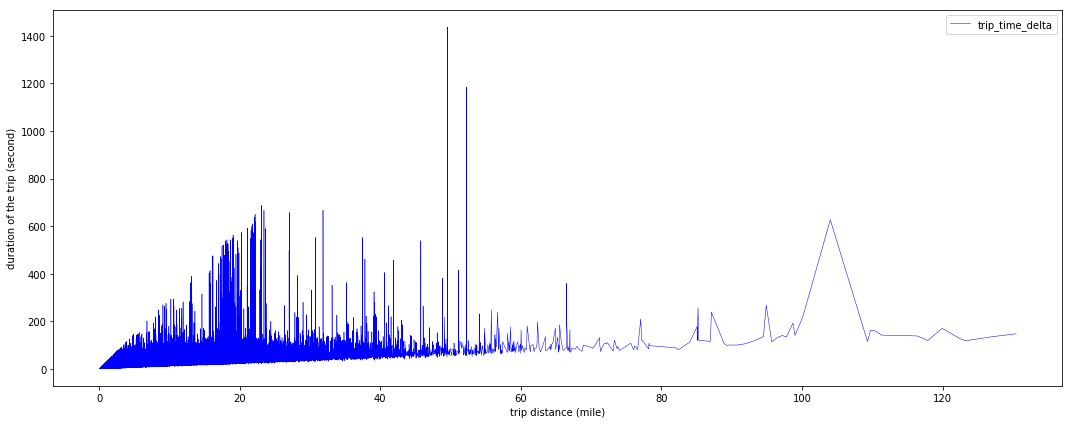

In [20]:
ax = sorted_data_below_200.plot(x='trip_distance', y='trip_time_delta', linestyle='solid', linewidth=0.5, color='blue')
ax.set_xlabel('trip distance (mile)')
ax.set_ylabel('duration of the trip (second)')
plt.tight_layout(rect=(0, 0, 2.5, 1.5))
plt.show()

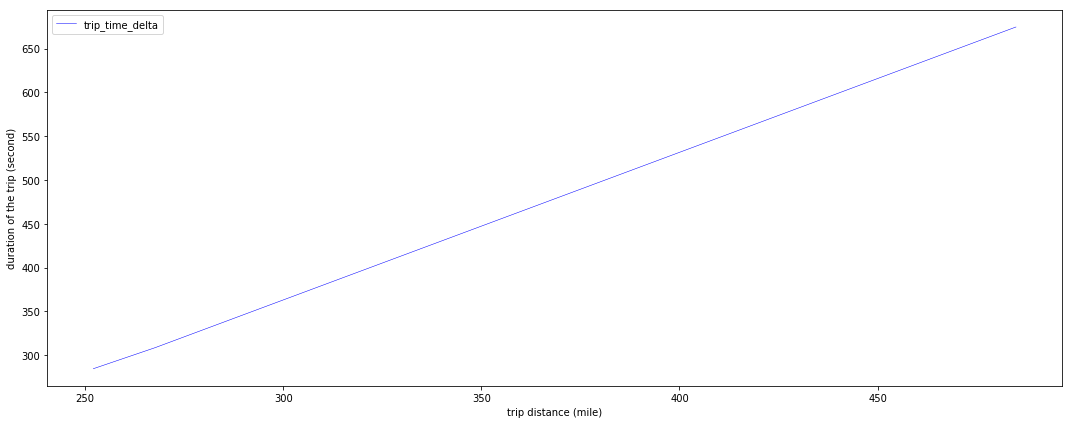

In [21]:
ax = sorted_data_above_200.plot(x='trip_distance', y='trip_time_delta', linestyle='solid', linewidth=0.5, color='blue')
ax.set_xlabel('trip distance (mile)')
ax.set_ylabel('duration of the trip (second)')
plt.tight_layout(rect=(0, 0, 2.5, 1.5))
plt.show()

### calculating Pearson Coefficient

In [22]:
pearson_coefficient = scipy.stats.pearsonr(sorted_data['trip_distance'], sorted_data['trip_time_delta'])[0]
print('Pearson Coefficient is :',pearson_coefficient)

Pearson Coefficient is : 0.7936921101685512


### plot Pearson Coefficient

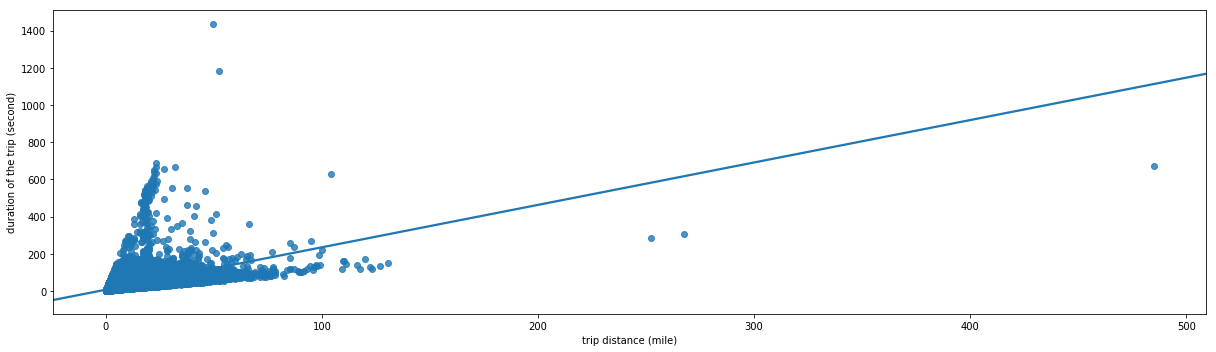

In [23]:
fig = plt.figure(figsize=(17,5))
sns.regplot(x="trip_distance", y="trip_time_delta", fit_reg=True, data=sorted_data);
plt.xlabel('trip distance (mile)');
plt.ylabel('duration of the trip (second)');

fig.tight_layout()
plt.show()

In [24]:
del sorted_data

In [25]:
del sorted_data_below_200

In [26]:
del sorted_data_above_200

In [27]:
sorted_data_all=[]

for M in range(1,7):
    data = pd.read_csv('yellow_tripdata_2018-0' + str(M) + '.csv', usecols = ['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'trip_distance', 'PULocationID'])
    data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'])
    data['tpep_dropoff_datetime'] = pd.to_datetime(data['tpep_dropoff_datetime'])
    data['tpep_pickup_datetime'].describe()
    data['tpep_dropoff_datetime'].describe()

    lookup_data = pd.read_csv('taxi_zone_lookup.csv')
    
    Data = pd.merge(data, lookup_data, left_on = data['PULocationID'], right_on = lookup_data['LocationID'])
    
    del data
    del lookup_data
    
    trip_time_delta = Data['tpep_dropoff_datetime'] - Data['tpep_pickup_datetime']
    trip_time_delta = trip_time_delta.dt.total_seconds().astype(int)
    Data['trip_time_delta'] = trip_time_delta / 60
    Data['taxi_speed'] = Data['trip_distance'] / (Data['trip_time_delta'] / 60)
    Data = Data[(Data['taxi_speed'] >= 2) & (Data['trip_time_delta'] != 0)]
    sorted_data = Data.sort_values(by=['trip_distance','trip_time_delta']) 
    
    del Data 
    
    sorted_data_all.append(sorted_data.drop(labels=['tpep_pickup_datetime','tpep_dropoff_datetime','PULocationID','LocationID','Borough','Zone','service_zone','taxi_speed'], axis=1))
    
    del sorted_data

In [31]:
sorted_data = pd.concat([sorted_data_all[0], sorted_data_all[1], sorted_data_all[2], sorted_data_all[3], sorted_data_all[4], sorted_data_all[5]])

In [32]:
del sorted_data_all

### calculating Pearson Coefficient

In [34]:
pearson_coefficient = scipy.stats.pearsonr(sorted_data['trip_distance'], sorted_data['trip_time_delta'])[0]
print('Pearson Coefficient is :',pearson_coefficient)

Pearson Coefficient is : 0.11324549754607528


### plot Pearson Coefficient

In [37]:
fig = plt.figure(figsize=(17,5))
sns.regplot(x="trip_distance", y="trip_time_delta", fit_reg=True, data=sorted_data);
plt.xlabel('trip distance (mile)');
plt.ylabel('duration of the trip (second)');

fig.tight_layout()
plt.show()

MemoryError: 

<Figure size 1224x360 with 0 Axes>

In [38]:
sorted_data_below_200 = sorted_data.loc[sorted_data['trip_distance'] < 200]
sorted_data_above_200 = sorted_data.loc[sorted_data['trip_distance'] >= 200] 

MemoryError: 

In [ ]:
del sorted_data

### plot for data that their trip distance are less than 200

In [ ]:
ax = sorted_data_below_200.plot(x='trip_distance', y='trip_time_delta', linestyle='solid', linewidth=0.5, color='blue')
ax.set_xlabel('trip distance (mile)')
ax.set_ylabel('duration of the trip (second)')
plt.tight_layout(rect=(0, 0, 2.5, 1.5))
plt.show()

### plot for data that their trip distance are more than 200

In [ ]:
ax = sorted_data_above_200.plot(x='trip_distance', y='trip_time_delta', linestyle='solid', linewidth=0.5, color='blue')
ax.set_xlabel('trip distance (mile)')
ax.set_ylabel('duration of the trip (second)')
plt.tight_layout(rect=(0, 0, 2.5, 1.5))
plt.show()

### [CRQ1] Does the fare for mile change across NY's borough? We want to discover whether the expenses of a user that enjoys Taxis in one zone is different from those that uses it in another one.

In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

In [2]:
data = pd.read_csv('yellow_tripdata_2018-01.csv',usecols = ['tpep_pickup_datetime', 'tpep_dropoff_datetime','trip_distance',
                   'PULocationID', 'fare_amount'])

In [4]:
data.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,PULocationID,fare_amount
0,2018-01-01 00:21:05,2018-01-01 00:24:23,0.5,41,4.5
1,2018-01-01 00:44:55,2018-01-01 01:03:05,2.7,239,14.0
2,2018-01-01 00:08:26,2018-01-01 00:14:21,0.8,262,6.0
3,2018-01-01 00:20:22,2018-01-01 00:52:51,10.2,140,33.5
4,2018-01-01 00:09:18,2018-01-01 00:27:06,2.5,246,12.5


In [3]:
# we decided to change the type of DataFrame columns to datetime,
# because we need the length of the trips for further DataFrame filtering

data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'])
data['tpep_dropoff_datetime'] = pd.to_datetime(data['tpep_dropoff_datetime'])

In [6]:
# we noticed that pickup dates also has some strange data,
# and as we are investigating only speciefic month,
# we decided to clean everything what happened on other time.

data['tpep_pickup_datetime'].describe()
data['tpep_dropoff_datetime'].describe()

count                 8759874
unique                2315061
top       2018-01-22 00:00:00
freq                       69
first     2001-01-05 11:52:05
last      2018-07-27 04:46:57
Name: tpep_dropoff_datetime, dtype: object

In [5]:
lookup_data = pd.read_csv('taxi _zone_lookup.csv')

In [8]:
lookup_data.head()

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


In [6]:
# We merged on 'PULocationID' because we are going to investigate dataset watching to the area of departure
Data = pd.merge(data, lookup_data, left_on = data['PULocationID'], right_on = lookup_data['LocationID'])

In [7]:
del data

In [8]:
del lookup_data

In [12]:
Data.head()

,key_0,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,PULocationID,fare_amount,LocationID,Borough,Zone,service_zone
0,41,2018-01-01 00:21:05,2018-01-01 00:24:23,0.50,41,4.5,41,Manhattan,Central Harlem,Boro Zone
1,41,2018-01-01 00:49:32,2018-01-01 00:59:52,1.36,41,8.5,41,Manhattan,Central Harlem,Boro Zone
2,41,2018-01-01 00:11:56,2018-01-01 00:14:35,0.30,41,4.0,41,Manhattan,Central Harlem,Boro Zone
3,41,2018-01-01 00:58:32,2018-01-01 01:43:45,14.10,41,41.5,41,Manhattan,Central Harlem,Boro Zone
4,41,2018-01-01 00:14:09,2018-01-01 00:44:06,8.77,41,29.0,41,Manhattan,Central Harlem,Boro Zone


In [9]:
Data = Data[Data['trip_distance']!= 0]

In [10]:
# P is the price per mile for each trip
Data['P'] = Data['fare_amount'] / Data['trip_distance']

In [11]:
Data = Data.drop(labels=['fare_amount','trip_distance'], axis=1)

In [12]:
Boroughs = ['Manhattan', 'Bronx', 'Queens', 'Staten Island', 'Brooklyn', 'EWR']

In [13]:
# the mean  of the new variable (P) for each borough
mean_dict_P = {borough:np.mean(Data['P'][Data['Borough'] == borough]) for borough in Boroughs}

In [14]:
mean_dict_P

{'Manhattan': 6.711718734305137,
 'Bronx': 8.69723160889051,
 'Queens': 6.465742462526548,
 'Staten Island': 13.778499036682351,
 'Brooklyn': 6.388790362112558,
 'EWR': 606.9924508922613}

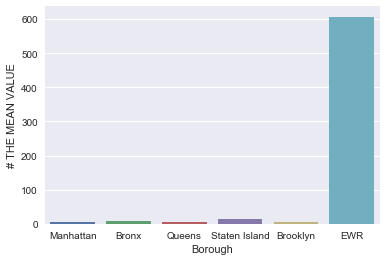

In [15]:
# plot the distribution of P - THE MEAN
sns.set(style="darkgrid")
ax = sns.barplot(list(mean_dict_P.keys()), list(mean_dict_P.values()))
ax.set(xlabel='Borough', ylabel='# THE MEAN VALUE')
plt.show()

In [16]:
# the standard deviation of the new variable (P) for each borough
standard_deviation_dict_P = {borough:np.std(Data['P'][Data['Borough'] == borough]) for borough in Boroughs}

In [17]:
standard_deviation_dict_P

{'Manhattan': 43.17906761450254,
 'Bronx': 70.8452591521763,
 'Queens': 100.87829739614122,
 'Staten Island': 60.35068532619004,
 'Brooklyn': 81.40376765867057,
 'EWR': 1684.6653002285257}

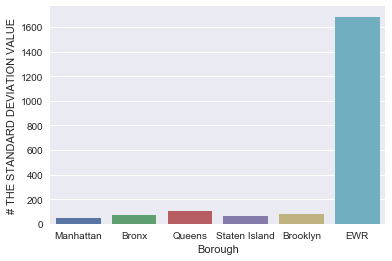

In [18]:
# plot the distribution of P - THE STANDARD DEVIATION
sns.set(style="darkgrid")
ax = sns.barplot(list(standard_deviation_dict_P.keys()), list(standard_deviation_dict_P.values()))
ax.set(xlabel='Borough', ylabel='# THE STANDARD DEVIATION VALUE')
plt.show()

In [19]:
# T is the time needed to complete the trip. (Minute)
T = Data['tpep_dropoff_datetime'] - Data['tpep_pickup_datetime']
Data['T'] = T.dt.total_seconds().astype(int)

In [20]:
Data = Data.drop(labels=['tpep_dropoff_datetime','tpep_pickup_datetime'], axis=1)

In [21]:
# P2 is P/T
Data['P2'] = Data['P'] / Data['T']

In [22]:
# cleaning Data from inf and nan values
Data = Data.replace([np.inf, -np.inf, 0], np.nan).dropna(subset=["P", "P2", 'T'], how="all")

In [36]:
Data.head()

,key_0,PULocationID,LocationID,Borough,Zone,service_zone,P,T,P2
0,41,41,41,Manhattan,Central Harlem,Boro Zone,9.000000,198.0,0.045455
1,41,41,41,Manhattan,Central Harlem,Boro Zone,6.250000,620.0,0.010081
2,41,41,41,Manhattan,Central Harlem,Boro Zone,13.333333,159.0,0.083857
3,41,41,41,Manhattan,Central Harlem,Boro Zone,2.943262,2713.0,0.001085
4,41,41,41,Manhattan,Central Harlem,Boro Zone,3.306727,1797.0,0.001840


In [23]:
# the mean  of the new variable (P2) for each borough
mean_dict_P2 = {borough:np.mean(Data['P2'][Data['Borough'] == borough]) for borough in Boroughs}

In [24]:
mean_dict_P2

{'Manhattan': 0.06923631909378704,
 'Bronx': 0.5566997155323379,
 'Queens': 0.32241514311821723,
 'Staten Island': 0.343921907240466,
 'Brooklyn': 0.13045468135406985,
 'EWR': 123.97481361463176}

In [25]:
# the standard deviation of the new variable (P2) for each borough
standard_deviation_dict_P2 = {borough:np.std(Data['P2'][Data['Borough'] == borough]) for borough in Boroughs}

In [26]:
standard_deviation_dict_P2

{'Manhattan': 7.476112954389468,
 'Bronx': 17.978196540244298,
 'Queens': 20.75247035205383,
 'Staten Island': 1.7663870710150211,
 'Brooklyn': 7.132662136086448,
 'EWR': 481.96065107481144}

In [27]:
del Data

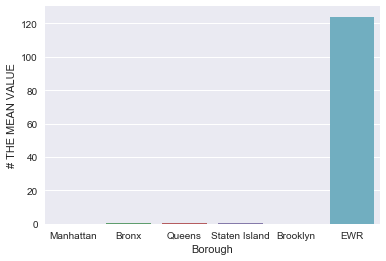

In [28]:
# plot the distribution of P2 - THE MEAN
sns.set(style="darkgrid")
ax = sns.barplot(list(mean_dict_P2.keys()), list(mean_dict_P2.values()))
ax.set(xlabel='Borough', ylabel='# THE MEAN VALUE')
plt.show()

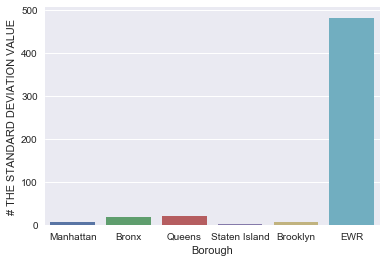

In [29]:
# plot the distribution of P2 - THE STANDARD DEVIATION
sns.set(style="darkgrid")
ax = sns.barplot(list(standard_deviation_dict_P2.keys()), list(standard_deviation_dict_P2.values()))
ax.set(xlabel='Borough', ylabel='# THE STANDARD DEVIATION VALUE')
plt.show()

In [31]:
boroughs = ['Manhattan', 'Bronx', 'Queens', 'Staten Island', 'Brooklyn', 'EWR']
taxi_boroughsP = {borough:pd.DataFrame(columns=['P']) for borough in boroughs}
taxi_boroughsP2 = {borough:pd.DataFrame(columns=['P2']) for borough in boroughs}

for M in range(1,7):
    data = pd.read_csv('yellow_tripdata_2018-0' + str(M) + '.csv',usecols = ['tpep_pickup_datetime', 
                                    'tpep_dropoff_datetime','trip_distance', 'PULocationID', 'fare_amount'])
    
    data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'])
    data['tpep_dropoff_datetime'] = pd.to_datetime(data['tpep_dropoff_datetime'])
    data['tpep_pickup_datetime'].describe()
    data['tpep_dropoff_datetime'].describe()
    
    lookup_data = pd.read_csv('taxi _zone_lookup.csv')
    Data = pd.merge(data, lookup_data, left_on = data['PULocationID'], right_on = lookup_data['LocationID'])
    del data
    del lookup_data
    
    Data = Data[Data['trip_distance']!= 0]
    Data['P'] = Data['fare_amount'] / Data['trip_distance']
    Data = Data.drop(labels=['fare_amount','trip_distance'], axis=1)
    T = Data['tpep_dropoff_datetime'] - Data['tpep_pickup_datetime']
    Data['T'] = T.dt.total_seconds().astype(int)
    Data = Data[Data['T']!= 0]    
    Data = Data.drop(labels=['tpep_dropoff_datetime','tpep_pickup_datetime'], axis=1)
    Data['P2'] = Data['P'] / Data['T']
    Data = Data.replace([np.inf, -np.inf, 0], np.nan).dropna(subset=["P", "P2", 'T'], how="all")
    
    for borough in boroughs:
        taxi_boroughsP[borough] = taxi_boroughsP[borough].append(pd.DataFrame(Data[Data['Borough'] == borough],
                                                                              columns = ['P']))
        taxi_boroughsP2[borough] = taxi_boroughsP2[borough].append(pd.DataFrame(Data[Data['Borough'] == borough],
                                                                                columns = ['P2']))
    del Data

In [48]:
boroughs = ['Manhattan', 'Bronx', 'Queens', 'Staten Island', 'Brooklyn', 'EWR']
taxi_boroughsP = {borough:pd.DataFrame(columns=['P']) for borough in boroughs}
taxi_boroughsP2 = {borough:pd.DataFrame(columns=['P2']) for borough in boroughs}
for M in range(1,7):
    data = pd.read_csv('yellow_tripdata_2018-0' + str(M) + '.csv',usecols = ['tpep_pickup_datetime', 
                                    'tpep_dropoff_datetime','trip_distance', 'PULocationID', 'fare_amount'])
    data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'])
    data['tpep_dropoff_datetime'] = pd.to_datetime(data['tpep_dropoff_datetime'])
    
    lookup_data = pd.read_csv('taxi _zone_lookup.csv')
    Data = pd.merge(data, lookup_data, left_on = data['PULocationID'], right_on = lookup_data['LocationID'])
    del data
    del lookup_data
    Data = Data[Data['trip_distance']!= 0]
    Data['P'] = Data['fare_amount'] / Data['trip_distance']
    Data = Data.drop(labels=['fare_amount','trip_distance'], axis=1)
    T = Data['tpep_dropoff_datetime'] - Data['tpep_pickup_datetime']
    Data['T'] = T.dt.total_seconds().astype(int)
    Data = Data[Data['T']!= 0]
    Data = Data.drop(labels=['tpep_dropoff_datetime','tpep_pickup_datetime'], axis=1)
    Data['P2'] = Data['P'] / Data['T']
    Data.replace([np.inf, -np.inf, 0], np.nan).dropna(subset=["P", "P2", 'T'], how="all")
    for borough in boroughs:
        taxi_boroughsP[borough] = taxi_boroughsP[borough].append(pd.DataFrame(Data[Data['Borough'] == borough], columns = ['P']))
        taxi_boroughsP2[borough] = taxi_boroughsP2[borough].append(pd.DataFrame(Data[Data['Borough'] == borough], columns = ['P2']))

In [32]:
taxi_boroughsP.keys()

dict_keys(['Manhattan', 'Bronx', 'Queens', 'Staten Island', 'Brooklyn', 'EWR'])

In [33]:
taxi_boroughsP2.keys()

dict_keys(['Manhattan', 'Bronx', 'Queens', 'Staten Island', 'Brooklyn', 'EWR'])

In [34]:
# the mean of the new variable (P) for each borough
mean_dict_P={}
for item in taxi_boroughsP.keys():
    mean_dict_P.update({item:np.mean(taxi_boroughsP.get(item))})

In [35]:
mean_dict_P

{'Manhattan': P    6.757256
 dtype: float64, 'Bronx': P    8.770516
 dtype: float64, 'Queens': P    6.705311
 dtype: float64, 'Staten Island': P    22.457171
 dtype: float64, 'Brooklyn': P    6.157742
 dtype: float64, 'EWR': P    903.849141
 dtype: float64}

In [36]:
# the standard deviation of the new variable (P) for each borough
standard_deviation_dict_P={}
for item in taxi_boroughsP2.keys():
    standard_deviation_dict_P.update({item:np.std(taxi_boroughsP.get(item))})

In [37]:
standard_deviation_dict_P

{'Manhattan': P    61.61181
 dtype: float64, 'Bronx': P    110.002876
 dtype: float64, 'Queens': P    108.568672
 dtype: float64, 'Staten Island': P    128.102585
 dtype: float64, 'Brooklyn': P    58.406324
 dtype: float64, 'EWR': P    2346.814588
 dtype: float64}

In [38]:
# the mean  of the new variable (P2) for each borough
mean_dict_P2={}
for item in taxi_boroughsP2.keys():
    mean_dict_P2.update({item:np.mean(taxi_boroughsP2.get(item))})

In [39]:
mean_dict_P2

{'Manhattan': P2    0.070385
 dtype: float64, 'Bronx': P2    0.448317
 dtype: float64, 'Queens': P2    0.331589
 dtype: float64, 'Staten Island': P2    1.349238
 dtype: float64, 'Brooklyn': P2    0.12298
 dtype: float64, 'EWR': P2    154.335092
 dtype: float64}

In [40]:
# the standard deviation of the new variable (P2) for each borough
standard_deviation_dict_P2={}
for item in taxi_boroughsP2.keys():
    standard_deviation_dict_P2.update({item:np.std(taxi_boroughsP2.get(item))})

In [41]:
standard_deviation_dict_P2

{'Manhattan': P2    7.683622
 dtype: float64, 'Bronx': P2    22.129949
 dtype: float64, 'Queens': P2    19.468433
 dtype: float64, 'Staten Island': P2    12.788652
 dtype: float64, 'Brooklyn': P2    9.012863
 dtype: float64, 'EWR': P2    660.248811
 dtype: float64}

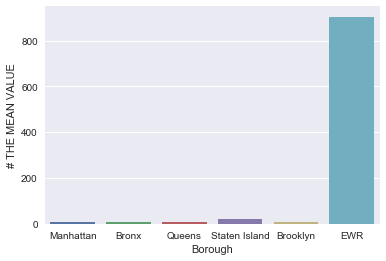

In [42]:
# plot the distribution of P - THE MEAN
sns.set(style="darkgrid")
ax = sns.barplot(list(mean_dict_P.keys()), list(mean_dict_P.values()))
ax.set(xlabel='Borough', ylabel='# THE MEAN VALUE')
plt.show()

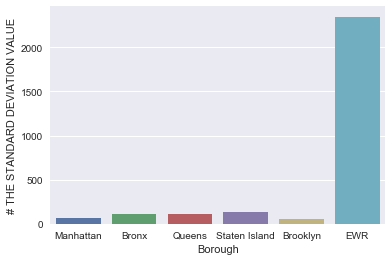

In [43]:
# plot the distribution of P - THE STANDARD DEVIATION
sns.set(style="darkgrid")
ax = sns.barplot(list(standard_deviation_dict_P.keys()), list(standard_deviation_dict_P.values()))
ax.set(xlabel='Borough', ylabel='# THE STANDARD DEVIATION VALUE')
plt.show()

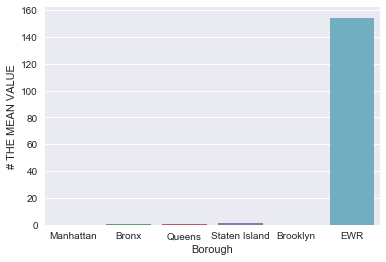

In [44]:
# plot the distribution of P2 - THE MEAN
sns.set(style="darkgrid")
ax = sns.barplot(list(mean_dict_P2.keys()), list(mean_dict_P2.values()))
ax.set(xlabel='Borough', ylabel='# THE MEAN VALUE')
plt.show()

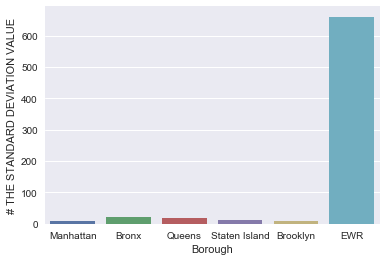

In [45]:
# plot the distribution of P2 - THE STANDARD DEVIATION
sns.set(style="darkgrid")
ax = sns.barplot(list(standard_deviation_dict_P2.keys()), list(standard_deviation_dict_P2.values()))
ax.set(xlabel='Borough', ylabel='# THE STANDARD DEVIATION VALUE')
plt.show()

Now we are going to execute a t-test for indepent samples, in order to see if Taxis trip in some boroughs, on average, are more expensive than others.

Our null hypothess H0 says that on avarage the trips have the same price among the boroughs Our alternative hypothesis H1 says that trips in some boroughs are more expensive than trips in others.

We set a significance level of 5%, for example.

In [49]:
stat, p = ttest_ind(taxi_boroughsP['Manhattan']['P'], taxi_boroughsP['Bronx']['P'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
stat, p = ttest_ind(taxi_boroughsP['Manhattan']['P'], taxi_boroughsP['Queens']['P'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
stat, p = ttest_ind(taxi_boroughsP['Manhattan']['P'], taxi_boroughsP['Staten Island']['P'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
stat, p = ttest_ind(taxi_boroughsP['Manhattan']['P'], taxi_boroughsP['Brooklyn']['P'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
stat, p = ttest_ind(taxi_boroughsP['Manhattan']['P'], taxi_boroughsP['EWR']['P'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
stat, p = ttest_ind(taxi_boroughsP['Bronx']['P'], taxi_boroughsP['Queens']['P'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
stat, p = ttest_ind(taxi_boroughsP['Bronx']['P'], taxi_boroughsP['Staten Island']['P'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
stat, p = ttest_ind(taxi_boroughsP['Bronx']['P'], taxi_boroughsP['Brooklyn']['P'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
stat, p = ttest_ind(taxi_boroughsP['Bronx']['P'], taxi_boroughsP['EWR']['P'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
stat, p = ttest_ind(taxi_boroughsP['Queens']['P'], taxi_boroughsP['Staten Island']['P'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
stat, p = ttest_ind(taxi_boroughsP['Queens']['P'], taxi_boroughsP['Brooklyn']['P'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
stat, p = ttest_ind(taxi_boroughsP['Queens']['P'], taxi_boroughsP['EWR']['P'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
stat, p = ttest_ind(taxi_boroughsP['Staten Island']['P'], taxi_boroughsP['Brooklyn']['P'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
stat, p = ttest_ind(taxi_boroughsP['Staten Island']['P'], taxi_boroughsP['EWR']['P'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
stat, p = ttest_ind(taxi_boroughsP['Brooklyn']['P'], taxi_boroughsP['EWR']['P'])
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=-7.406, p=0.000
Statistics=1.474, p=0.141
Statistics=-6.262, p=0.000
Statistics=7.942, p=0.000
Statistics=-455.919, p=0.000
Statistics=4.292, p=0.000
Statistics=-3.026, p=0.002
Statistics=9.011, p=0.000
Statistics=-79.421, p=0.000
Statistics=-3.567, p=0.000
Statistics=4.003, p=0.000
Statistics=-244.531, p=0.000
Statistics=6.851, p=0.000
Statistics=-9.058, p=0.000
Statistics=-256.157, p=0.000


Looking at our results we can see that the majority of the p-values are very small, less than 0.05, that is the significance we decided before. So we can say that are significant, therefore we reject the null hypothesis. This means that the price of the trip for some boroughs are more expensive than others.

But the p-value between the datas of Manhattan and Queens is higher than the significance level (0.141 > 0.05), so we accept the null hypthesis, and we can say that the price of trips in Manhattan is the same of the price for trips in Queens.

Now we execute the t-test for the values of the prices weighted for trip duration, in order to see if something changes if we consider the traffic.

In [50]:
stat, p = ttest_ind(taxi_boroughsP2['Manhattan']['P2'], taxi_boroughsP2['Bronx']['P2'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
stat, p = ttest_ind(taxi_boroughsP2['Manhattan']['P2'], taxi_boroughsP2['Queens']['P2'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
stat, p = ttest_ind(taxi_boroughsP2['Manhattan']['P2'], taxi_boroughsP2['Staten Island']['P2'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
stat, p = ttest_ind(taxi_boroughsP2['Manhattan']['P2'], taxi_boroughsP2['Brooklyn']['P2'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
stat, p = ttest_ind(taxi_boroughsP2['Manhattan']['P2'], taxi_boroughsP2['EWR']['P2'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
stat, p = ttest_ind(taxi_boroughsP2['Bronx']['P2'], taxi_boroughsP2['Queens']['P2'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
stat, p = ttest_ind(taxi_boroughsP2['Bronx']['P2'], taxi_boroughsP2['Staten Island']['P2'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
stat, p = ttest_ind(taxi_boroughsP2['Bronx']['P2'], taxi_boroughsP2['Brooklyn']['P2'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
stat, p = ttest_ind(taxi_boroughsP2['Bronx']['P2'], taxi_boroughsP2['EWR']['P2'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
stat, p = ttest_ind(taxi_boroughsP2['Queens']['P2'], taxi_boroughsP2['Staten Island']['P2'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
stat, p = ttest_ind(taxi_boroughsP2['Queens']['P2'], taxi_boroughsP2['Brooklyn']['P2'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
stat, p = ttest_ind(taxi_boroughsP2['Queens']['P2'], taxi_boroughsP2['EWR']['P2'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
stat, p = ttest_ind(taxi_boroughsP2['Staten Island']['P2'], taxi_boroughsP2['Brooklyn']['P2'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
stat, p = ttest_ind(taxi_boroughsP2['Staten Island']['P2'], taxi_boroughsP2['EWR']['P2'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
stat, p = ttest_ind(taxi_boroughsP2['Brooklyn']['P2'], taxi_boroughsP2['EWR']['P2'])
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=-11.155, p=0.000
Statistics=-51.421, p=0.000
Statistics=-4.118, p=0.000
Statistics=-5.553, p=0.000
Statistics=-592.079, p=0.000
Statistics=1.350, p=0.177
Statistics=-0.998, p=0.318
Statistics=6.789, p=0.000
Statistics=-49.866, p=0.000
Statistics=-1.287, p=0.198
Statistics=8.590, p=0.000
Statistics=-214.131, p=0.000
Statistics=3.361, p=0.001
Statistics=-5.616, p=0.000
Statistics=-174.559, p=0.000


We still have that the majority of p-values are less than the significance level of 0.05, so in general we reject the null hypothesis, and we can say that the price of trips depends on the borough.

But this time we do not have a big p-value between the boroughs of Manhattan and Queens, instead we have a bigger p-value in respect to alpha = 0.05 comparing Bronx and Queens, Bronx and Staten Island and Queens and State Island (respectively 0.177, 0.318, 0.198 > 0.05). This means that between those pairs the trip price is the same, beacuse we accept the null hypothesis. Therefore, considering the estimation error we can say that Bronx, Staten Island and Queens have the same trip price.

Comparing the results between the p-values of the normal trip price and the ones of the weighted trip price we can notice that if we consider even the traffic, the difference among the prices of the boroughts is not so evident. So we can say that it is right to take in account the traffic.

#### CRQ2: Visualize Taxis movements! 
NYC is divided in many Taxis zones. For each yellow cab trip we know the zone the Taxi pick up and drop off the users. Let's visualize, on a chropleth map, the number of trips that starts in each zone. Than, do another map to count the races that end up in the single zone. Comment your discoveries. To perform this task we use the library folium. You find some examples of chorophlet maps here and here. The Geojson we use to trace the zones is taxi_zones.json in the Homework's repository.

In [1]:
import pandas as pd
import folium
import os
import json

Firslty we import our data sets, clean them, and calculating the number of rides for each pick up and drop off zone

In [2]:
Location_data_pickup = []
Location_data_dropoff = []
for M in range(1,7):
    # importing data set, with only columns we need for current analysis
    data = pd.read_csv('yellow_tripdata_2018-0' + str(M) + '.csv', 
                       usecols = ['tpep_pickup_datetime', 'tpep_dropoff_datetime',
                                  'trip_distance', 'PULocationID', 'DOLocationID'])
    
    # we decided to change the type of DataFrame columns to datetime,
    # because we need the length of the trips for further DataFrame filtering
    data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'])
    data['tpep_dropoff_datetime'] = pd.to_datetime(data['tpep_dropoff_datetime'])
    
    # we create these columns for furter cleaning data by filtering
    data['month'] = pd.DatetimeIndex(data['tpep_pickup_datetime']).month
    data['year'] = pd.DatetimeIndex(data['tpep_pickup_datetime']).year
    
    #filtering data
    data = data[(data['month'] == M) & (data['year'] == 2018)]
    
    # deleting columns month and year as we dont need them anymore
    data = data.drop(labels=['month','year'], axis=1)
    
    # column 'trip_time_delta' is the representation of duration of a ride in minutes
    # column 'taxi_speed' is the average speed of moving in miles per hour
    trip_time_delta = data['tpep_dropoff_datetime'] - data['tpep_pickup_datetime']
    trip_time_delta = trip_time_delta.dt.total_seconds().astype(int)
    data['trip_time_delta'] = trip_time_delta / 60
    data['taxi_speed'] = data['trip_distance'] / (data['trip_time_delta'] / 60)
    
    #filtering data
    data = data[(data['taxi_speed'] >= 2) & (data['trip_time_delta'] >= 1) & (data['taxi_speed'] < 65)]
    
    # deleting columns month and year as we dont need them anymore
    data_PU = data.drop(labels=['trip_time_delta','taxi_speed', 'tpep_pickup_datetime',
                             'tpep_dropoff_datetime', 'trip_distance','DOLocationID'], axis=1)
    data_DO = data.drop(labels=['trip_time_delta','taxi_speed', 'tpep_pickup_datetime',
                             'tpep_dropoff_datetime', 'trip_distance','PULocationID'], axis=1)
    del data
    
    #lists which store series with the number of rides for each month and for each NY zone
    Location_data_pickup.append(data_PU.groupby(['PULocationID'])['PULocationID'].count())
    Location_data_dropoff.append(data_DO.groupby(['DOLocationID'])['DOLocationID'].count())
    del data_PU
    del data_DO

In [3]:
# PUrides_num is a dataframe with the number of rides for each month for each NY pick up area
PUrides_num = pd.concat([Location_data_pickup[0], Location_data_pickup[1],
                        Location_data_pickup[2], Location_data_pickup[3],
                        Location_data_pickup[4], Location_data_pickup[5]], axis=1)
PUrides_num.columns = ['01', '02', '03', '04', '05', '06']
# filling NaN vlues with zeroes
PUrides_num = PUrides_num.fillna(0)
# PUrides is a Series where areas' numbers are indexes and sums for all 6 months are values
PUrides = PUrides_num.sum(axis=1)

In [4]:
# DOrides_num is a dataframe with the number of rides for each month for each NY drop off area
DOrides_num = pd.concat([Location_data_dropoff[0], Location_data_dropoff[1],
                        Location_data_dropoff[2], Location_data_dropoff[3],
                        Location_data_dropoff[4], Location_data_dropoff[5]], axis=1)
DOrides_num.columns = ['01', '02', '03', '04', '05', '06']
# filling NaN vlues with zeroes
DOrides_num = DOrides_num.fillna(0)
# DOrides is a Series where areas' numbers are indexes and sums for all 6 months are values
DOrides = DOrides_num.sum(axis=1)

In [5]:
# loading json file with coordinates of each zone
ny_json = json.load(open('taxi_zones.json'))

In [6]:
mPU = folium.Map(location=[40.8, -73.9],tiles='Mapbox Bright', zoom_start=10)
folium.GeoJson(ny_json).add_to(mPU)
mPU.choropleth(
   geo_data=ny_json,
   name='choropleth',
   data=PUrides,
   key_on='feature.properties.LocationID',
   fill_color='BuPu',
   fill_opacity=0.7,
   line_opacity=0.2,
   legend_name='the number of trips that starts in each zone'
)

In [7]:
mPU.save('mPU.html')

In [8]:
del mPU

In [9]:
mDO = folium.Map(location=[40.8, -73.9], tiles='Mapbox Bright', zoom_start=10)
folium.GeoJson(ny_json).add_to(mDO)
mDO.choropleth(
   geo_data=ny_json,
   name='choropleth',
   data=DOrides,
   key_on='feature.properties.LocationID',
   fill_color='BuPu',
   fill_opacity=0.7,
   line_opacity=0.2,
   legend_name='the number of trips that end up in each zone'
)

In [10]:
mDO.save('mDO.html')

In [11]:
del mDO

#### Comments:

Let’s start from Staten Island. We can see on pick up map that the only active zone is zone # 99, and it is extremely popular, while in the drop off map zone # 110 has much more drop offs than zone # 99. 

Bronx area is not popular on both maps. And it's not surprising, because when we were analyzing the number of rides which start from this area is was around 200-300 rides each month.

Brooklyn area is in the same state as Bronx. The only difference is that it has 3000 rides each month which is nothing in comparison with Manhattan.

EWR area was the last popular in our analysis in the RQ1, because it has only 1 pick up ride per month on average,
so here we can see this fact visually.

Queens is the second top district in terms of number of rides, so we can see that there are two main zones: # 138 and # 132, and there are more pick up rides, especially in zone # 138, then drop off rides. 

Manhattan is the most popular zone in the whole NY. Most pick ups and drop offs are performed from island zones: # 103, # 104, # 105. However, almost all Manhattan is covered with bright color. Lower Manhattan is a bit less popular than Midtown, while areas around Central Park such as Upper west side and of course Upper east side are the zones with the biggest number of pick ups and drop off, except from zones # 103, # 104, # 105.
